**Цель работы:** Приоритизировать гипотезы для увеличения выручки, запустить A/B-тест и проанализировать результаты.

Описание данных:

Файл /datasets/hypothesis.csv
1. Hypothesis — краткое описание гипотезы
2. Reach — охват пользователей по 10-балльной шкале
3. Impact — влияние на пользователей по 10-балльной шкале
4. Confidence — уверенность в гипотезе по 10-балльной шкале
5. Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv
1. transactionId — идентификатор заказа
2. visitorId — идентификатор пользователя, совершившего заказ
3. date — дата, когда был совершён заказ
4. revenue — выручка заказа
5. group — группа A/B-теста, в которую попал заказ

Файл /datasets/visitors.csv
1. date — дата
2. group — группа A/B-теста
3. visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**План работы:**

1. Открываем файл с данными и изучаем общую информацию
2. Подготавливаем данные
3. Приоритизируем гипотезы
4. Проводим анализ А/В теста:
- построим график кумулятивной выручки по группам;
- построим график кумулятивного среднего чека по группам;
- построим график относительного изменения кумулятивного среднего чека группы B к группе A; 
- построим график кумулятивного среднего количества заказов на посетителя по группам;
- построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
- построим точечный график количества заказов по пользователям;
- посчитаем 95-й и 99-й перцентили количества заказов на пользователя;
- построим точечный график стоимостей заказов;
- посчитаем 95-й и 99-й перцентили стоимости заказов;
- посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным; 
- посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным; 
- посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
- посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным;
5. Примем решение по результатам теста: остановить или продолжить тест;
6. Пишем общий вывод по проделаной работе

### Загрузка данных и подготовка их к анализу

Первым шагом загружаем данные, изучаем их и выполняем предобработку

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
import math

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
#выводим и просмариваем первые строки датафрейма hypothesis
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
#просматриваем информацию о файле, какой у каждого столбца тип данных
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
#проверяем наличие явных дубликатов
hypothesis.duplicated().sum()

0

In [5]:
#считаем количество пустых значений
hypothesis.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Все данные проверены, дубликатов нет, пустых значений нет, тип данных верный - можно идти дальше и проанализировать по такому же принципу датафрейм orders.

In [6]:
#выводим и просмариваем первые строки датафрейма orders
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
#просматриваем информацию о файле, какой у каждого столбца тип данных
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
#преобразуем данные столбца date к нужному типу данных
orders['date'] = pd.to_datetime(orders['date'])
#просматриваем информацию вновь
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
#проверяем наличие явных дубликатов
orders.duplicated().sum()

0

In [10]:
#считаем количество пустых значений
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Все данные проверены, дубликатов нет, пустых значений нет, тип данных изменили на верный - можно идти дальше и проанализировать по такому же принципу датафрейм visitors.

In [11]:
#выводим и просмариваем первые строки датафрейма visitors
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
#просматриваем информацию о файле, какой у каждого столбца тип данных
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
#преобразуем данные столбца date к нужному типу данных
visitors['date'] = pd.to_datetime(visitors['date'])
#просматриваем информацию вновь
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [14]:
#проверяем наличие явных дубликатов
visitors.duplicated().sum()

0

In [15]:
#считаем количество пустых значений
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Все данные проверены, дубликатов нет, пустых значений нет, тип данных изменили на верный.

Далее можно приступать к следующему шагу - приоритизации гипотез

### Приоритизация гипотез

- Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
- Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
- Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.

In [16]:
#выводем для просмотра весь датафрейм hypothesis, с которым будем далее работать
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [17]:
#создадим новый столбец ICE
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']).round(2)
#выводем отсортированный датафрейм для просмотра
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


In [18]:
#создадим новый столбец RICE
hypothesis['RICE'] = ((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']).round(2)
#выводем отсортированный датафрейм для просмотра
pd.options.display.max_colwidth = 120
hypothesis.sort_values(by = 'RICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


**По полученным данным видно, что приоритизация гипотез при применении ICE и RICE - меняется. При ICE лидерами становятся гипотезы 8, 0 и 7; при RICE - 7, 2 и 0 - гипотеза 8 "полетела" вниз, в то время как 2 гипотеза поднялась. Это связано с тем, что в RICE мы дополнительно учитываем параметр Reach (скольких пользователей затронет изменение, которое вы хотите внести) - в гипотезе 8 он составляет всего 1, а во 2 целых 8**

Далее переходим к следующему шагу - анализу A/B-теста

### Анализ А/В теста
- построим график кумулятивной выручки по группам
- построим график кумулятивного среднего чека по группам;
- построим график относительного изменения кумулятивного среднего чека группы B к группе A; 
- построим график кумулятивного среднего количества заказов на посетителя по группам;
- построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
- построим точечный график количества заказов по пользователям;
- посчитаем 95-й и 99-й перцентили количества заказов на пользователя;
- построим точечный график стоимостей заказов;
- посчитаем 95-й и 99-й перцентили стоимости заказов;
- посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным; 
- посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным; 
- посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
- посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным;

**1. Построим график кумулятивной выручки по группам**

In [19]:
#создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
#получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis = 1).sort_values(by = ['date','group'])
#получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis = 1).sort_values(by = ['date','group'])
#объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on = ['date', 'group'], right_on = ['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

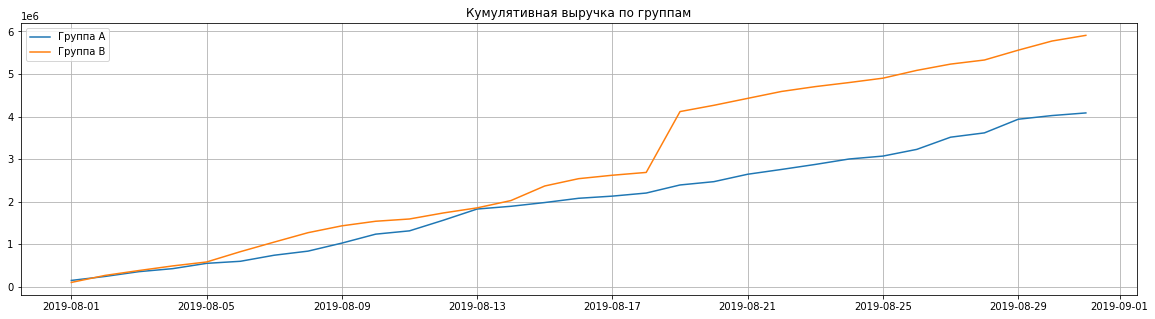

In [20]:
#датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
#датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]
plt.figure(figsize = (20,5))
#cтроим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'Группа A')
#cтроим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'Группа В')
plt.title('Кумулятивная выручка по группам')
plt.grid()
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако график выручки группы В в одной точке (примерно от 18-19.08.2019) резко вырос. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

In [21]:
#находим медианное значение выручки заказа
orders_median = orders['revenue'].median()
#создаем новую переменную, в которую входят данные только за 19.08.2019
orders_new = orders[orders['date'] == '2019-08-19']
#выведем только те записи, что больше медианы, чтобы найти возможный выброс
orders_new = orders_new[orders_new['revenue'] > orders_median]
orders_new

,transactionId,visitorId,date,revenue,group
318,3412626998,3282099314,2019-08-19,11985,A
366,2037051350,1957949546,2019-08-19,16770,A
367,1033377712,3860669668,2019-08-19,3990,B
368,3268879337,2536252163,2019-08-19,20026,B
421,3765974140,1357170471,2019-08-19,31680,A
422,181836088,3528043184,2019-08-19,9490,A
423,4161654914,990904712,2019-08-19,11249,B
425,590470918,1920142716,2019-08-19,1294500,B
428,791532781,4079050915,2019-08-19,4930,A
460,141445646,3017378493,2019-08-19,3190,A


Видим, что 19.08.2019 был один заказ на 1.3 млн рублей - можно посчитать его за выброс.

<div class="alert alert-block alert-success">

    
### Комментарий от ревьюера v_1

👍🏻
    
Но слишком большая таблица, стоило фильтровать не по медиане
    
</div>

**2. Построим график кумулятивного среднего чека по группам**

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

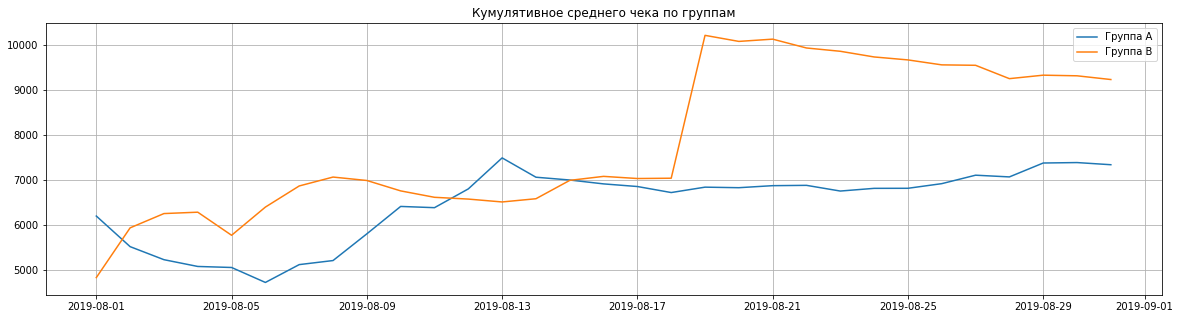

In [22]:
plt.figure(figsize = (20,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'Группа B')
plt.title('Кумулятивное среднего чека по группам')
plt.grid()
plt.legend();

По графику видно все то же влияние заказа группы В от 19.08.2019 года в размере 1.3 млн - график резко взлетел вверх - далее, однако, средний чек начал снижаться.

По группе А можно также заметить резкое повышение среднего чека от 13.08.2019 года - далее стабилизируется и находится на примерно одном уровне, но все же средний чек группы А находится ниже, чем у группы В.

**3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A**

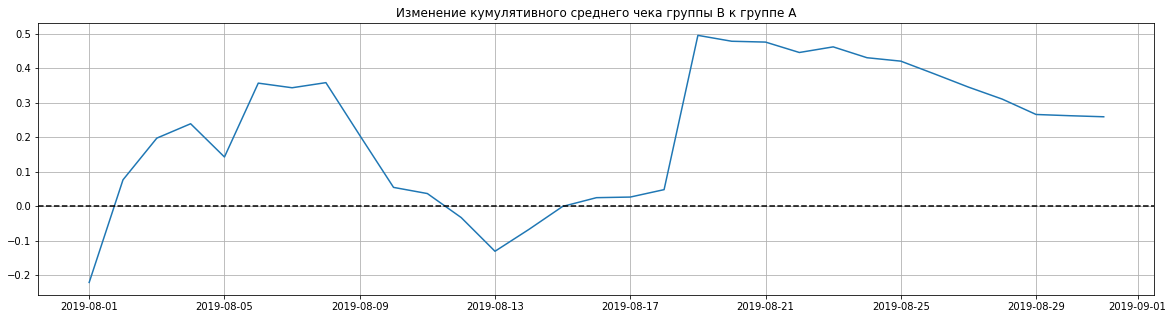

In [23]:
#собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])
#cтроим отношение средних чеков
plt.figure(figsize = (20,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
#добавляем ось X
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Изменение кумулятивного среднего чека группы B к группе A')
plt.grid()

По данному графику также видно влияние крупного заказа от 19.08.2019 - график резко летит вверх

Средний чек группы В был на протяжении всего времени теста выше, чем у группы А, кроме 12-14.08.2019 - где произошло резкое падение с таким же резким подъемом далее. По конец теста средний чек группы В начал постепенно снижаться.

**4. Построим график кумулятивного среднего количества заказов на посетителя по группам**

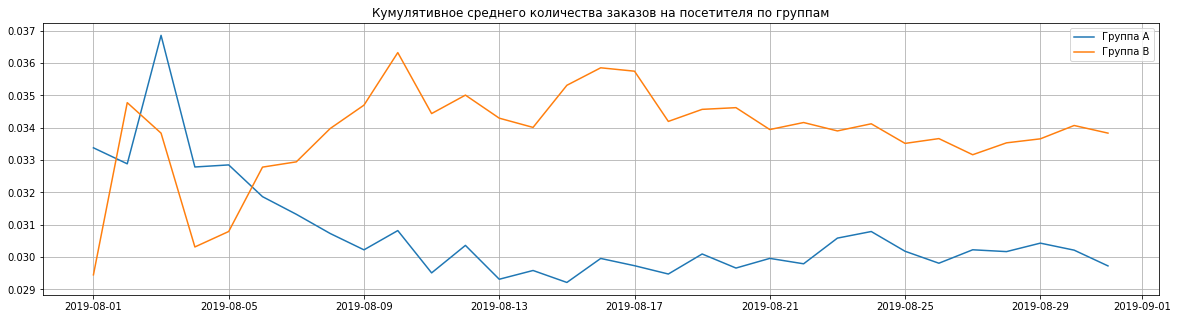

In [24]:
#датафрейм с кумулятивным количеством заказов и кумулятивным количеством посетителей по дням в группе А
cumulativeVisitorsA = cumulativeData[cumulativeData['group'] == 'A'][['date','visitors', 'orders']]
#датафрейм с кумулятивным количеством заказов и кумулятивным количеством посетителей по дням в группе B
cumulativeVisitorsB = cumulativeData[cumulativeData['group'] == 'B'][['date','visitors', 'orders']]
plt.figure(figsize = (20,5))
#cтроим график группы А
plt.plot(cumulativeVisitorsA['date'], cumulativeVisitorsA['orders'] / cumulativeVisitorsA['visitors'].unique(), label = 'Группа A')
#cтроим график группы B
plt.plot(cumulativeVisitorsB['date'], cumulativeVisitorsB['orders'] / cumulativeVisitorsB['visitors'].unique(), label = 'Группа B')
plt.title('Кумулятивное среднего количества заказов на посетителя по группам')
plt.grid()
plt.legend();

Количество заказов группы В, уже с 6.08.2019, стабильно больше заказов группы А и так до самого завершения теста.

**5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

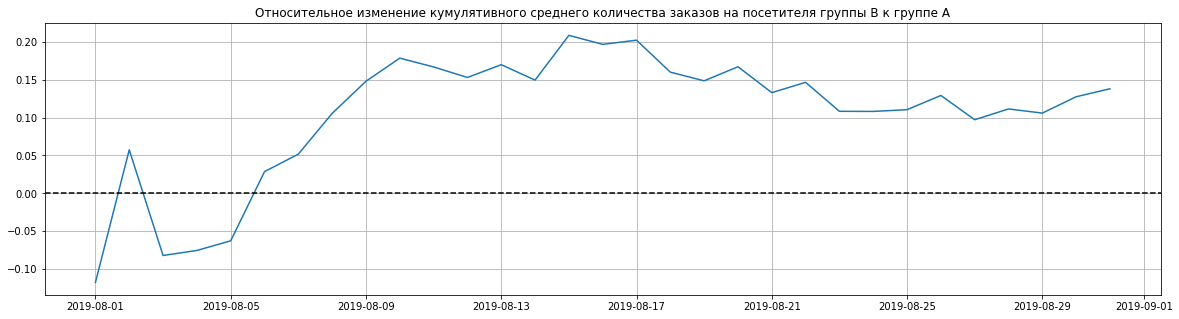

In [25]:
#собираем данные в одном датафрейме
mergedCumulativeVisitors = cumulativeVisitorsA.merge(cumulativeVisitorsB, left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])
#cтроим отношение средних чеков
plt.figure(figsize = (20,5))
plt.plot(mergedCumulativeVisitors['date'], (mergedCumulativeVisitors['ordersB'] / mergedCumulativeVisitors['visitorsB']) / (mergedCumulativeVisitors['ordersA'] / mergedCumulativeVisitors['visitorsA']) - 1)
#добавляем ось X
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.grid();

Первое время от начала теста (1 и 3-6.08.2019) среднее количество заказов на посетителя группы А было выше, чем у группы В, однако далее произошел резкий подъем количества заказов и на таком (примерно одинаковом) уровне продержалось на всем протяжении оставшегося время проведения теста.

**6. Построим точечный график количества заказов по пользователям**

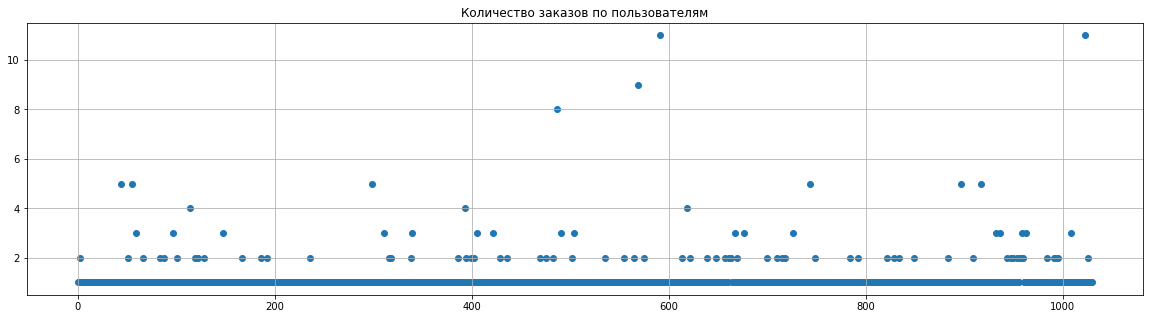

In [26]:
ordersByUsers = (
    orders.groupby('visitorId', as_index = False)
    .agg({'transactionId': 'nunique'})
)
plt.figure(figsize = (20,5))
plt.grid()
ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.title('Количество заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders']);

Наибольшее число тех пользователей, кто совершил 1 заказ - также достаточно часто совершали и 2 заказа, однако 3 и более встречаются редко - и можно считать это аномалиями (свыше 3).

**7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя**

In [27]:
percentile_95_order = round(np.percentile(ordersByUsers['orders'], 95))
print('95-й и 99-й перцентили количества заказов на пользователя равны', np.percentile(ordersByUsers['orders'], [95, 99]))

95-й и 99-й перцентили количества заказов на пользователя равны [2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказов. И не более 1% пользователей заказывали более 4 раз - следовательно, что выше 2 заказов - это аномалия. 

**8. Построим точечный график стоимостей заказов**

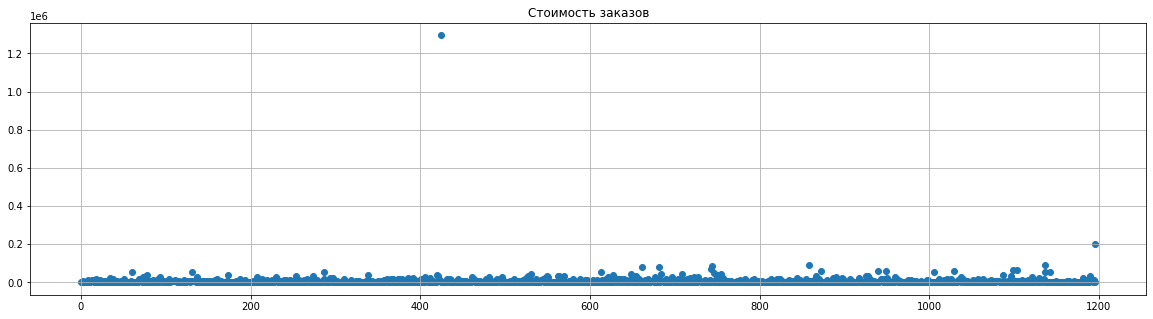

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize = (20,5))
plt.grid()
plt.title('Стоимость заказов')
plt.scatter(x_values, orders['revenue']);

На графике видно тот самый заказ на 1.3 млн - аномалия.

Данный график достаточно плохо прочитать, нужно построить более точный график - до 200.000 - где видна вторая возможная аномалия.

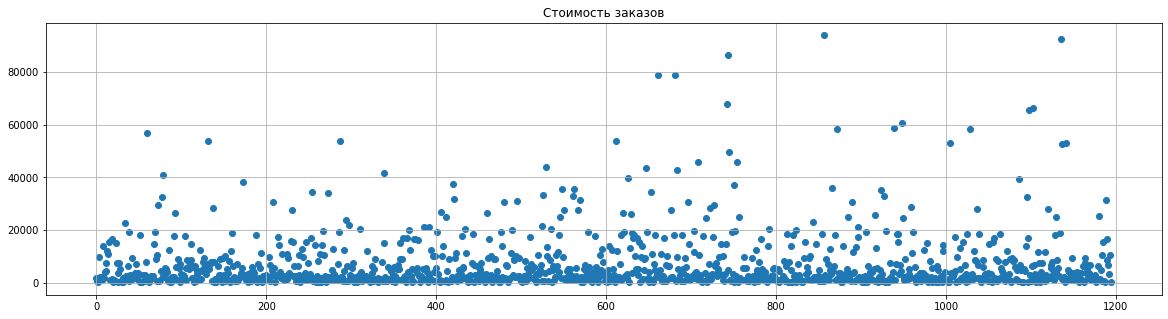

In [29]:
revenue_new = orders[orders['revenue'] <= 200000]['revenue']
x_values = pd.Series(range(0,len(revenue_new)))
plt.figure(figsize = (20,5))
plt.grid()
plt.title('Стоимость заказов')
plt.scatter(x_values, revenue_new);

По графику видно, что большиноство пользователей оформляют заказы на сумму до 40.000

**9. Посчитаем 95-й и 99-й перцентили стоимости заказов**

In [30]:
percentile_95_revenue = round(np.percentile(orders['revenue'], 95))
print('95-й и 99-й перцентили стоимости заказов равны', np.percentile(orders['revenue'], [95, 99]))

95-й и 99-й перцентили стоимости заказов равны [28000.  58233.2]


Не более 5% пользователей оформляли заказы более чем на 28.000. И не более 1% пользователей заказывали на сумму свыше 58.234 - следовательно, что выше суммы в 28.000 примем за аномалию.

**10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**

- Нулевая гипотеза - статистически значимых различий в среднем количестве заказов между группами нет
- Альтернативная гипотеза - статистически значимых различий в среднем количестве заказов между группами есть

Уровень значимости alpha = 0.05

In [31]:
#cоздадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitorId', 'orders'].
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [32]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index = np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name = 'orders',
        ),
    ],
    axis = 0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index = np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name = 'orders',
        ),
    ],
    axis = 0,
)

print('p-value', '{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('относительный показатель', '{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value 0.017
относительный показатель 0.138


P-value меньше alpha = 0.05. Значит гипотезу о том, что статистически значимых различий в среднем количестве заказов между группами нет, отвергаем. По «сырым» данным наблюдается статистически значимая разница в среднем количестве заказов на посетителя между группами A и B. Среднее количество заказов на посетителя группы B значительно выше показателей группы A (около 14%).

**11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**

- Нулевая гипотеза - статистически значимых различий в среднем чеке заказа между группами нет
- Альтернативная гипотеза - статистически значимых различий в чеке заказа между группами есть

In [33]:
print('p-value', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('относительный показатель', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value 0.729
относительный показатель 0.259


P-value значительно больше 0.05. Значит, причин отрицать нулевую гипотезу о том, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A (около 26%).

**12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным**

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > percentile_95_order]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > percentile_95_order]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > percentile_95_revenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
74


Всего 74 аномальных пользователей. 

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [36]:
#применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительный показатель', '{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean()-1)) 

p-value 0.013
относительный показатель 0.173


Результаты по среднему количеству заказов практически не изменились - по «очищенным» данным различия в конверсии групп A и B есть. Результаты группы В также опережают результаты группы А на 17% (по "сырым" данным на 14%)

**13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным**

In [37]:
print('p-value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue']
        )[1]
    )
)

print('относительный показатель',
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value 0.738
относительный показатель -0.020


P-value практически не увеличился, но разница между сегментами сократилась с 26% до 2% - средний чек группы B оказался незначительно ниже среднего чека группы A.

Нулевую гипотезу не отвергаем.

**14. Примем решение по результатам теста**


- И по "сырым" и по "очищенным" данным различия в среднем количестве заказов на посетителя групп A и B есть - результаты группы "B" выше результатов группы "A" на 17% по "очищенным" и 14% по "сырым" данным - **результат в пользу группы В**
- По "сырым" данным различия в среднем чеке посетителей групп A и B также есть - результаты группы "B" выше результатов группы "A" на 26%, в то время как по "очищенным" группа А выигрывает всего на 2% группу В - все это из-за аномально крупного заказа в 1.3 млн - но даже по такой результату можно говориить об отсутствии статистически значимых различий - **результат в пользу группы В**
- Кумулятивные метрики по выручке почти все время лидировали в группе B - **результат в пользу группы В**

**По проведенному анализу приходим к выводу, что тест можно остановить и зафиксировать победу группы В - она достаточно эффективнее группы А.**